In [1]:
import os
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.chdir('/home/jlm217/rds/rds-mrc-bsu-csoP2nj6Y6Y/mimah/stopah/stopah/data') 

pd.set_option('display.max_columns', None)  

ro.r['load']('STOPAH_ForSolon.RData')

def R_dataset(x):
    with (ro.default_converter + pandas2ri.converter).context():
        stopah = ro.conversion.get_conversion().rpy2py(ro.r[x])
    return stopah

stopah = R_dataset('stopah')

R[write to console]: Warning:
R[write to console]:  namespace ‘pROC’ is not available and has been replaced
by .GlobalEnv when processing object ‘roc.objs’



In [3]:
selected = ['D28_DTH','D90_DTH','Prednisolone']

sevenday = ['Hepatic.Encephalopathy...Treatment.Day.7..','Day.7.infection',
'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
'Temperature..Treatment.Day.7..','Pulse..Treatment.Day.7..','Systolic.BP..Treatment.Day.7..',
'Diastolic.BP..Treatment.Day.7..','MAP..Treatment.Day.7','Hb..1.decimal.point..Haematology..Treatment.Day.7..',
'Platelets.day.7','WBC.day.7','Neutrophils.day.7','INR.clinical.and.calc.day.7','Bilirubin.day.7',
'ALT.day.7','ALP.day.7','Albumin.day.7','Sodium.day.7','Potassium.day.7','Urea.day.7','Creatinine.day.7']

#reduce data set to target, treatment and therapy

stopah = stopah[sevenday+['D28_DTH','Prednisolone']]

stopah.reset_index(drop=True, inplace=True)

In [4]:
#Hot one encoding of variables 

categorical = ['Hepatic.Encephalopathy...Treatment.Day.7..', 'Day.7.infection',
              'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..']

for v in range(5):
    new = 'Hepatic.Encephalopathy...Treatment.Day.7..' + '_' +str(v)
    stopah[new] = stopah['Hepatic.Encephalopathy...Treatment.Day.7..'].apply(lambda x: 1 if x== v else 0 )
    
d = 'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..'

stopah['Day.7.infection1'] = stopah['Day.7.infection'].apply(lambda x: 1 if x== 0 else 0 )
stopah[d+str(1)] = stopah[d].apply(lambda x: 1 if x== 0 else 0 )

#stopah

In [5]:
for x in stopah.columns:
    if len(stopah[stopah[x] == -2147483648].index) >0:
        #print(x)
        #print(stopah[stopah[x] == -2147483648].index)
        stopah[x][stopah[x] ==-2147483648] = np.nan

/tmp/ipykernel_1237909/642612019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stopah[x][stopah[x] ==-2147483648] = np.nan
/tmp/ipykernel_1237909/642612019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stopah[x][stopah[x] ==-2147483648] = np.nan
/tmp/ipykernel_1237909/642612019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stopah[x][stopah[x] ==-2147483648] = np.nan
/tmp/ipykernel_1237909/642612019.py:5: SettingWithCo

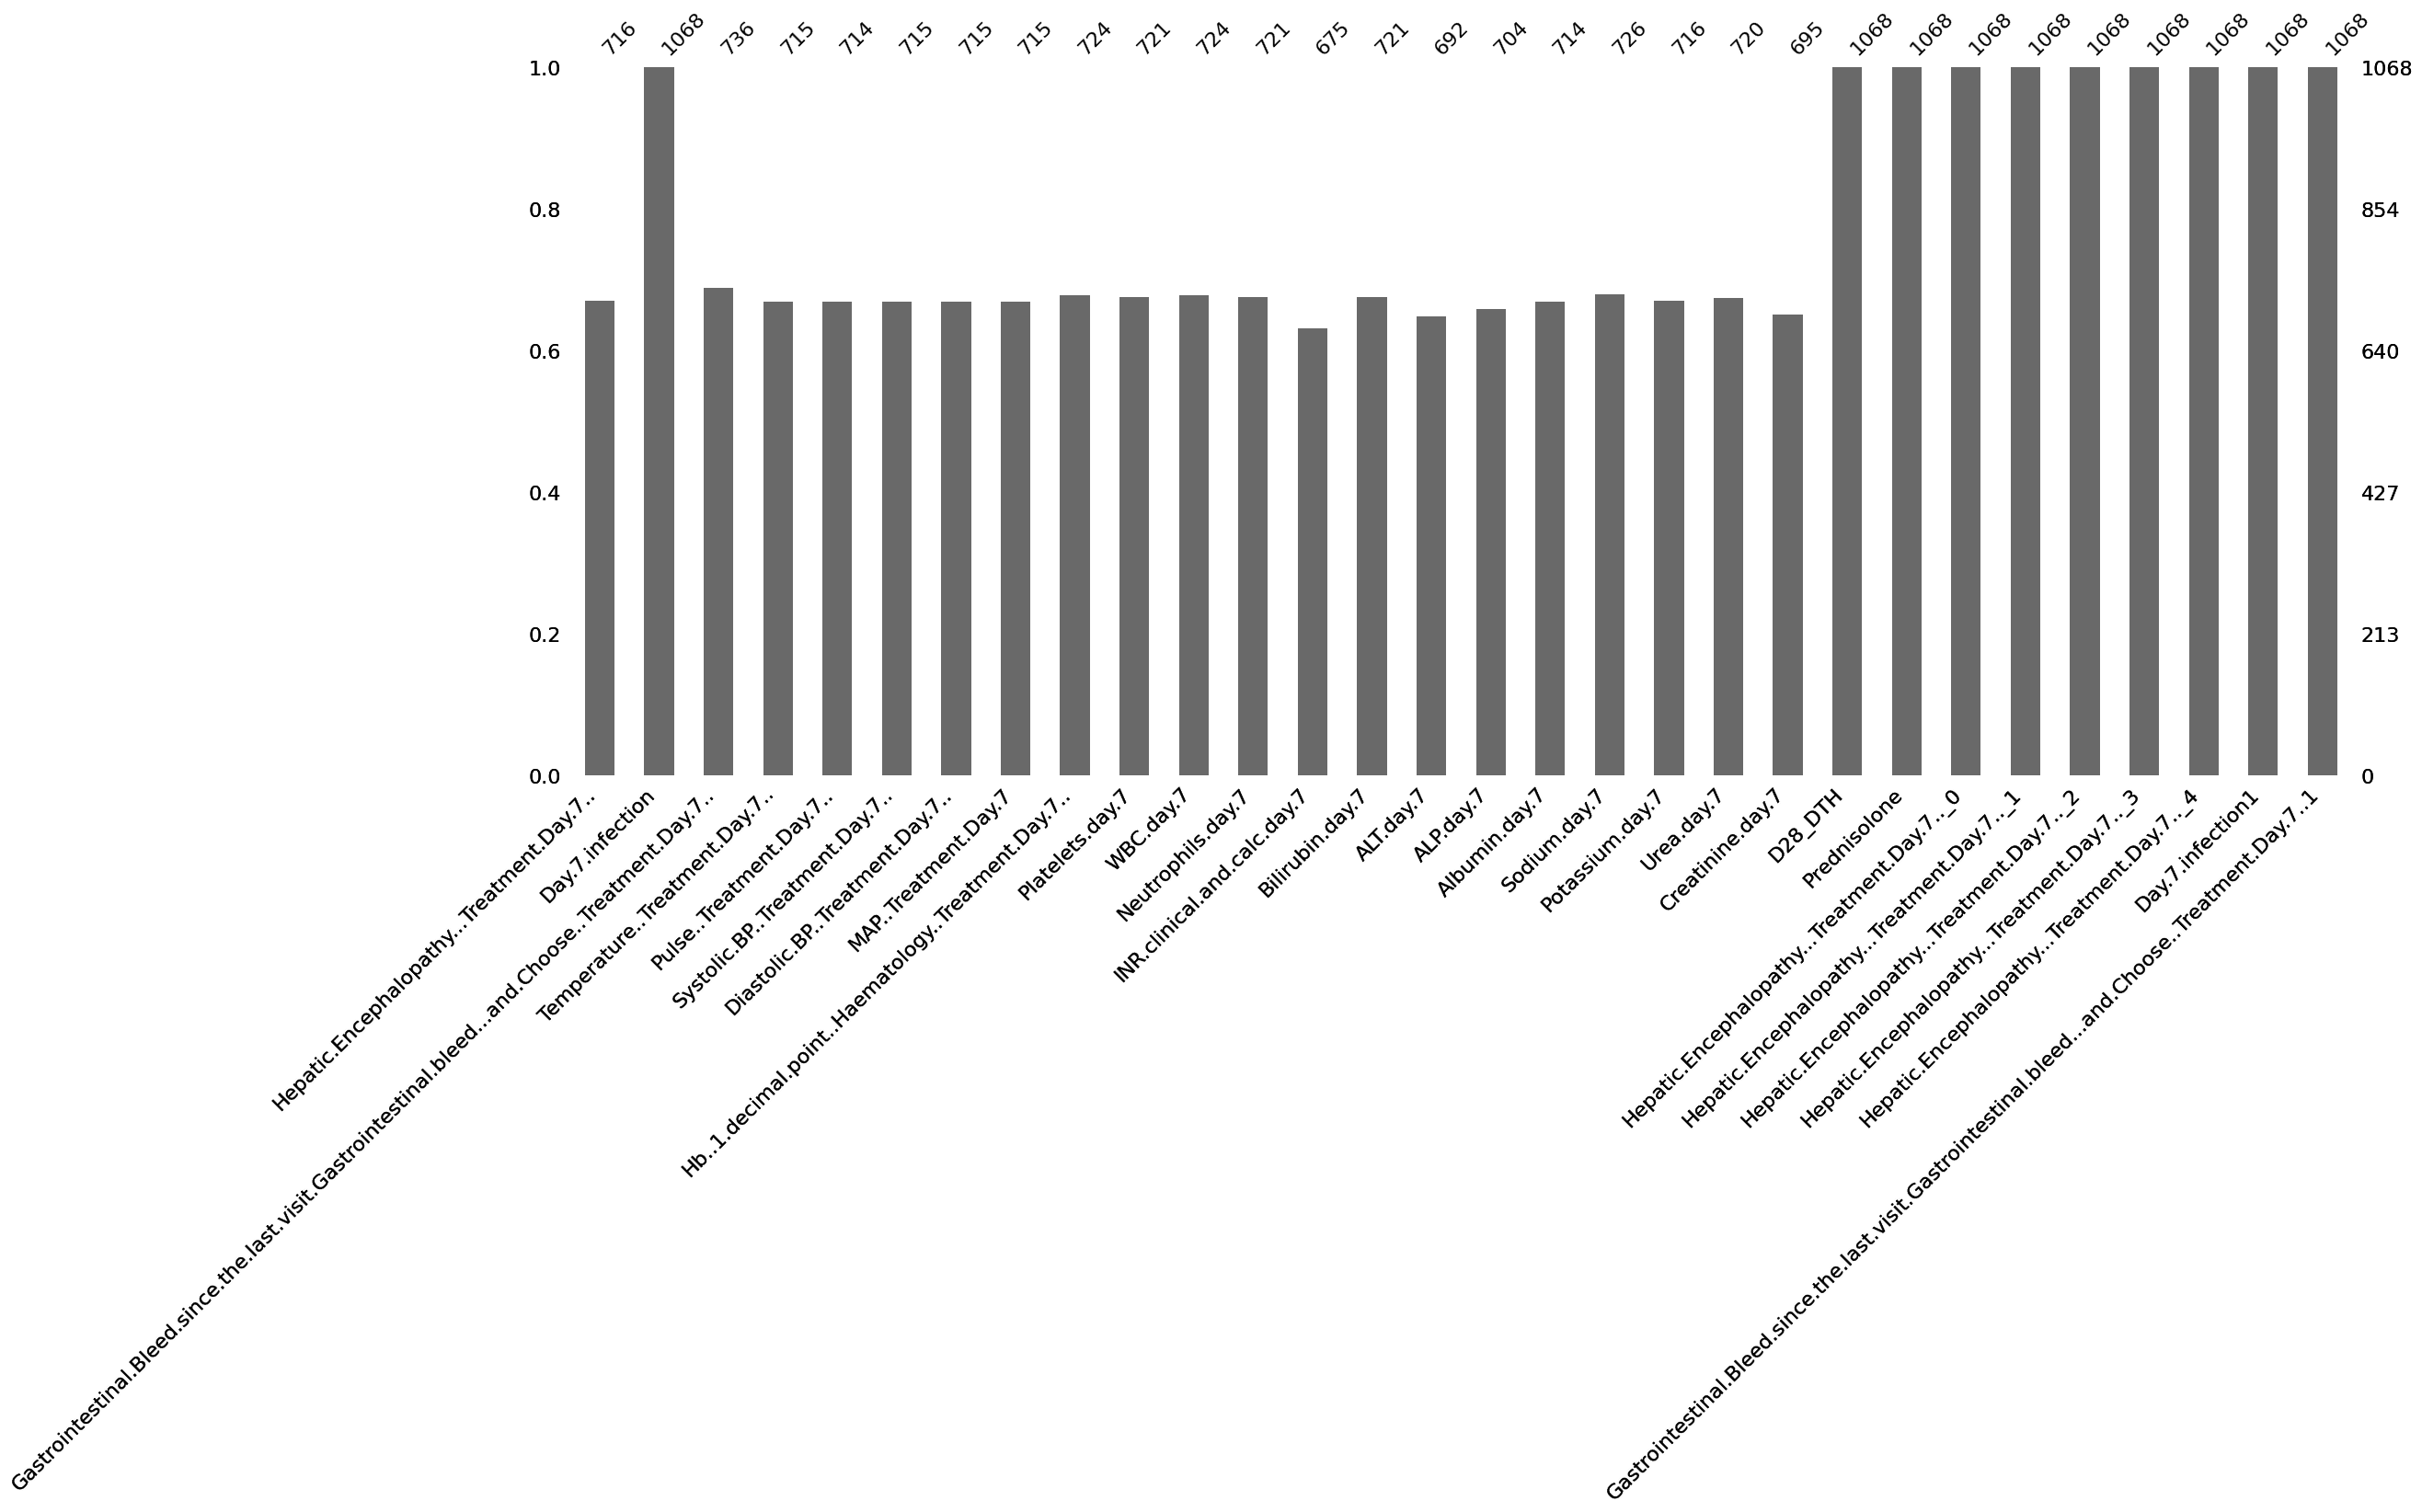

In [6]:
## Missing data situation

%matplotlib inline
msno.bar(stopah)
fig = msno.bar(stopah)
fig_copy = fig.get_figure()

In [7]:
#numerical variables 

missings = []

for x in stopah.columns:
    if (stopah[x].isna().sum())/len(stopah) > 0.0:
        missings.append(x)    

for mia in missings:
    mia_col1= mia + '_mia_1'
    mia_col2= mia + '_mia_2'
    
    stopah[mia_col1] =stopah[mia].fillna(-2147483648)
    stopah[mia_col2] =stopah[mia].fillna(2147483648)

In [8]:
stopah.drop(missings, axis=1, inplace=True) 

In [9]:
#Split into train-test based on treatment 

train = stopah.loc[stopah['Prednisolone']==0].drop(['Prednisolone'], axis=1)

test= stopah.loc[stopah['Prednisolone']==1].drop(['Prednisolone'], axis=1)

train.reset_index(drop=True)
test.reset_index(drop=True)

,Day.7.infection,D28_DTH,Hepatic.Encephalopathy...Treatment.Day.7.._0,Hepatic.Encephalopathy...Treatment.Day.7.._1,Hepatic.Encephalopathy...Treatment.Day.7.._2,Hepatic.Encephalopathy...Treatment.Day.7.._3,Hepatic.Encephalopathy...Treatment.Day.7.._4,Day.7.infection1,Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..1,Hepatic.Encephalopathy...Treatment.Day.7.._mia_1,Hepatic.Encephalopathy...Treatment.Day.7.._mia_2,Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7.._mia_1,Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7.._mia_2,Temperature..Treatment.Day.7.._mia_1,Temperature..Treatment.Day.7.._mia_2,Pulse..Treatment.Day.7.._mia_1,Pulse..Treatment.Day.7.._mia_2,Systolic.BP..Treatment.Day.7.._mia_1,Systolic.BP..Treatment.Day.7.._mia_2,Diastolic.BP..Treatment.Day.7.._mia_1,Diastolic.BP..Treatment.Day.7.._mia_2,MAP..Treatment.Day.7_mia_1,MAP..Treatment.Day.7_mia_2,Hb..1.decimal.point..Haematology..Treatment.Day.7.._mia_1,Hb..1.decimal.point..Haematology..Treatment.Day.7.._mia_2,Platelets.day.7_mia_1,Platelets.day.7_mia_2,WBC.day.7_mia_1,WBC.day.7_mia_2,Neutrophils.day.7_mia_1,Neutrophils.day.7_mia_2,INR.clinical.and.calc.day.7_mia_1,INR.clinical.and.calc.day.7_mia_2,Bilirubin.day.7_mia_1,Bilirubin.day.7_mia_2,ALT.day.7_mia_1,ALT.day.7_mia_2,ALP.day.7_mia_1,ALP.day.7_mia_2,Albumin.day.7_mia_1,Albumin.day.7_mia_2,Sodium.day.7_mia_1,Sodium.day.7_mia_2,Potassium.day.7_mia_1,Potassium.day.7_mia_2,Urea.day.7_mia_1,Urea.day.7_mia_2,Creatinine.day.7_mia_1,Creatinine.day.7_mia_2
0,0,0,0,1,0,0,0,1,1,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.610000e+01,3.610000e+01,7.500000e+01,7.500000e+01,1.100000e+02,1.100000e+02,7.200000e+01,7.200000e+01,8.466667e+01,8.466667e+01,1.220000e+02,1.220000e+02,1.070000e+02,1.070000e+02,2.300000e+01,2.300000e+01,2.140000e+01,2.140000e+01,1.000000e+00,1.000000e+00,2.400000e+01,2.400000e+01,1.950000e+02,1.950000e+02,3.260000e+02,3.260000e+02,1.600000e+01,1.600000e+01,1.350000e+02,1.350000e+02,3.800000e+00,3.800000e+00,8.700000e+00,8.700000e+00,5.400000e+01,5.400000e+01
1,0,0,0,0,0,0,0,1,0,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09
2,0,0,1,0,0,0,0,1,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.630000e+01,3.630000e+01,7.800000e+01,7.800000e+01,1.080000e+02,1.080000e+02,6.300000e+01,6.300000e+01,7.800000e+01,7.800000e+01,1.390000e+02,1.390000e+02,1.290000e+02,1.290000e+02,1.030000e+01,1.030000e+01,7.700000e+00,7.700000e+00,2.200000e+00,2.200000e+00,5.300000e+02,5.300000e+02,8.700000e+01,8.700000e+01,9.800000e+01,9.800000e+01,2.000000e+01,2.000000e+01,1.330000e+02,1.330000e+02,3.400000e+00,3.400000e+00,6.400000e+00,6.400000e+00,8.500000e+01,8.500000e+01
3,0,0,1,0,0,0,0,1,0,0.000000e+00,0.000000e+00,-2.147484e+09,2.147484e+09,3.680000e+01,3.680000e+01,8.900000e+01,8.900000e+01,1.270000e+02,1.270000e+02,6.900000e+01,6.900000e+01,8.833333e+01,8.833333e+01,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09
4,0,0,0,0,0,0,0,1,0,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,-2.147484e+09,2.14

In [10]:
X_train = train.drop(['D28_DTH'],axis=1)
y_train = train['D28_DTH']

X_test = test.drop(['D28_DTH'],axis=1)
y_test = test['D28_DTH']


In [11]:
#Balance weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)


rf = RandomForestClassifier(n_estimators=15,max_depth=8,random_state=24,criterion='gini',min_samples_split=10)

In [12]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=10, n_estimators=15,
                       random_state=24)

In [13]:
pred_prob = rf.predict_proba(X_test)

auc_score = roc_auc_score(y_test, pred_prob[:,1])

print('Training accuracy: ', np.mean(rf.predict(X_train) ==y_train)*100) 
print ('Test accuracy:', np.mean(rf.predict(X_test) ==y_test)*100)
print('AUC Score:',(auc_score)*100)

Training accuracy:  92.13483146067416
Test accuracy: 85.76779026217228
AUC Score: 75.77051561365286


In [14]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)

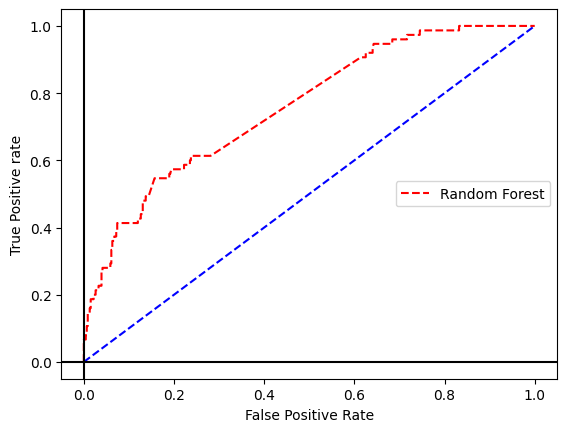

In [15]:
plt.axes(facecolor='white')
# plot roc curves

plt.plot(fpr, tpr, linestyle='--',color='red',label='Random Forest') #label='Random Forest'
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

#plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.grid(False)

plt.axhline(0, color='black')
plt.axvline(0, color='black')

#ax = fig.add_axes([1,1,0,0])

#ax.set_facecolor("white")

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

